In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10



from datetime import datetime, timedelta,date
from __future__ import division

import plotly.offline as pyoff
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

#import Keras
import keras
from keras.layers import LSTM,Dropout,Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM

from sklearn.model_selection import KFold, cross_val_score, train_test_split #split data in testing and training portion
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing #standardize data
from sklearn.linear_model import LinearRegression



In [24]:
df = pd.read_excel('TTC_historical_ridership_data.xlsx') #set up pandas DataFrame from excel file
df

,Unnamed: 0,FARE MEDIA,2019,2018,2017,2016,2015 *,2014,2013,2012,...,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985
0,WHO,ADULT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,PRESTO - 1 RIDE & 2 RIDE TICKET,1906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,PRESTO - DAY PASS,829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,PRESTO - ADULT SINGLE RIDE,166871.0,110950.0,67829.0,27397.0,13323.0,9862.0,8194.0,4399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,PRESTO - ADULT TFE SINGLE RIDE,4340.0,1496.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,NaN,SUB-TOTAL,290079.0,256866.0,272103.0,285180.0,295062.0,289523.0,285226.0,279425.0,...,197232.0,204425.0,211756.0,235017.0,256553.0,252648.0,255418.0,253484.0,252100.0,239470.0
58,NaN,SYSTEM TOTAL,525470.0,521404.0,533216.0,538079.0,534005.0,534815.0,525194.0,514007.0,...,388252.0,393485.0,404251.0,424167.0,459234.0,450726.0,463475.0,456884.0,441012.0,432160.0
59,WHEN,WEEKDAY,426300.0,417245.0,424155.0,424117.0,423808.0,423269.0,416297.0,406913.0,...,319087.0,324529.0,334515.0,350714.0,379987.0,374024.0,385093.0,382917.0,369295.0,358947.0
60,NaN,WEEKEND/HOLIDAY,99170.0,104159.0,109061.0,113962.0,110197.0,111546.0,108897.0,107094.0,...,69165.0,68956.0,69736.0,73453.0,79247.0,76702.0,78382.0,73967.0,71717.0,73213.0


In [25]:
df_list = df.values.tolist()
df_list = df_list[-1] #Get just the System Totals Row (row 61)
df_list = df_list[2:] # Ignore the NaN and System total cells
df_list = df_list[::-1] #reverse list order to have an ascending order by yaer

columns = ['N_PPL']
df_list = pd.DataFrame(list(df_list), columns=columns) #create new dataframe with system total 

df_list['Year'] = pd.date_range(start='1985', periods=len(df_list), freq='Y').year #add year column

df = df_list

df



,N_PPL,Year
0,432160.0,1985
1,441012.0,1986
2,456884.0,1987
3,463475.0,1988
4,450726.0,1989
5,459234.0,1990
6,424167.0,1991
7,404251.0,1992
8,393485.0,1993
9,388252.0,1994


Text(0, 0.5, 'Number of People using the TTC ( /1000)')

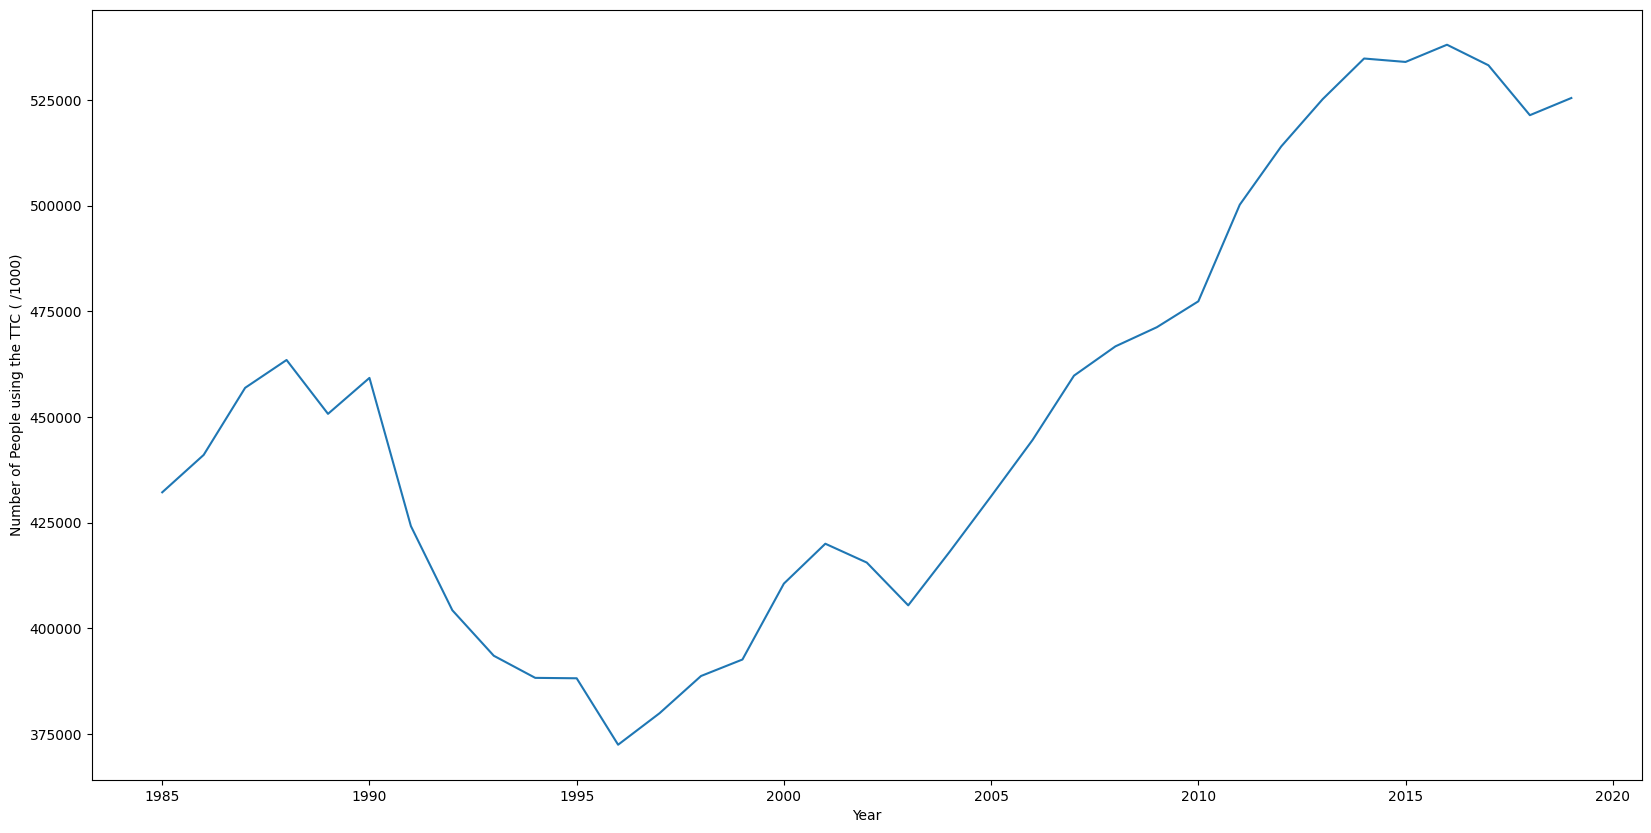

In [26]:
plt.plot( df['Year'].values.tolist() , df['N_PPL'].values.tolist() ) #plot graph of Number of ppl taking the TTC per year
plt.xlabel('Year')
plt.ylabel('Number of People using the TTC ( /1000)')

In [27]:
forecast = 3 #forecast variable represents how many years in the future I'm trying to predict
df['Prediction'] = df["N_PPL"].shift(-3) #Create a prediction row and keep 3 cells blank before inserting predicted values

df



,N_PPL,Year,Prediction
0,432160.0,1985,463475.0
1,441012.0,1986,450726.0
2,456884.0,1987,459234.0
3,463475.0,1988,424167.0
4,450726.0,1989,404251.0
5,459234.0,1990,393485.0
6,424167.0,1991,388252.0
7,404251.0,1992,388152.0
8,393485.0,1993,372430.0
9,388252.0,1994,379883.0


In [63]:
#X dataset feautures
#Y datatset is labels

X = np.array(df.drop(['Prediction'],1)) #drop prediction column in order to not corrupt preprocessing
X = preprocessing.scale(X) #standardize data setting the mean = 0 and std = 1

X_forecast = X[-forecast:] #preprocessing still accounts for last 3 years so we need to index the data to exclude the last 3 years
X = X[:-forecast] #all but the last 3 years

y = np.array(df['Prediction']) 
y = y[:-forecast] #all but last 3 years

#ensured X and Y have same length

print("X_forecast :\n",X_forecast)
print("X :\n", X)
print("y:",y)

X_forecast :
 [[1.59760779 1.48522131]
 [1.36830001 1.58423607]
 [1.44723376 1.68325082]]
X :
 [[-0.36420457 -1.68325082]
 [-0.19235962 -1.58423607]
 [ 0.11576543 -1.48522131]
 [ 0.24371731 -1.38620656]
 [-0.00378057 -1.28719181]
 [ 0.16138627 -1.18817705]
 [-0.51937365 -1.0891623 ]
 [-0.90600537 -0.99014754]
 [-1.11500703 -0.89113279]
 [-1.21659589 -0.79211803]
 [-1.21853721 -0.69310328]
 [-1.5237503  -0.59408853]
 [-1.3790643  -0.49507377]
 [-1.20811236 -0.39605902]
 [-1.13232353 -0.29704426]
 [-0.78356681 -0.19802951]
 [-0.60040402 -0.09901475]
 [-0.68687006  0.        ]
 [-0.88346674  0.09901475]
 [-0.63717247  0.19802951]
 [-0.38245291  0.29704426]
 [-0.12379248  0.39605902]
 [ 0.17177229  0.49507377]
 [ 0.30632463  0.59408853]
 [ 0.39432431  0.69310328]
 [ 0.51321026  0.79211803]
 [ 0.95703304  0.89113279]
 [ 1.22470115  0.99014754]
 [ 1.44187573  1.0891623 ]
 [ 1.62864937  1.18817705]
 [ 1.61292474  1.28719181]
 [ 1.6920138   1.38620656]]
y: [463475. 450726. 459234. 424167. 4042

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) # split train and test datasets using an 80/20 split
clf = LinearRegression() #initialize linear regression model and classifier
clf.fit(X_train,y_train) #initialize model with training data

confidence = clf.score(X_test,y_test) #score our data on test datasets to ensure we have an accurate model
confidence #the closer to 1 the confidence level is the more accurate the model

0.9319667498597429

In [81]:
forecast_predicted = clf.predict(X_forecast) #predict what is our model going to predict on the 3 years were looking for
forecast_predicted #predicted values for the next 3 years

array([543317.37126322, 537735.77533592, 542542.68554883])

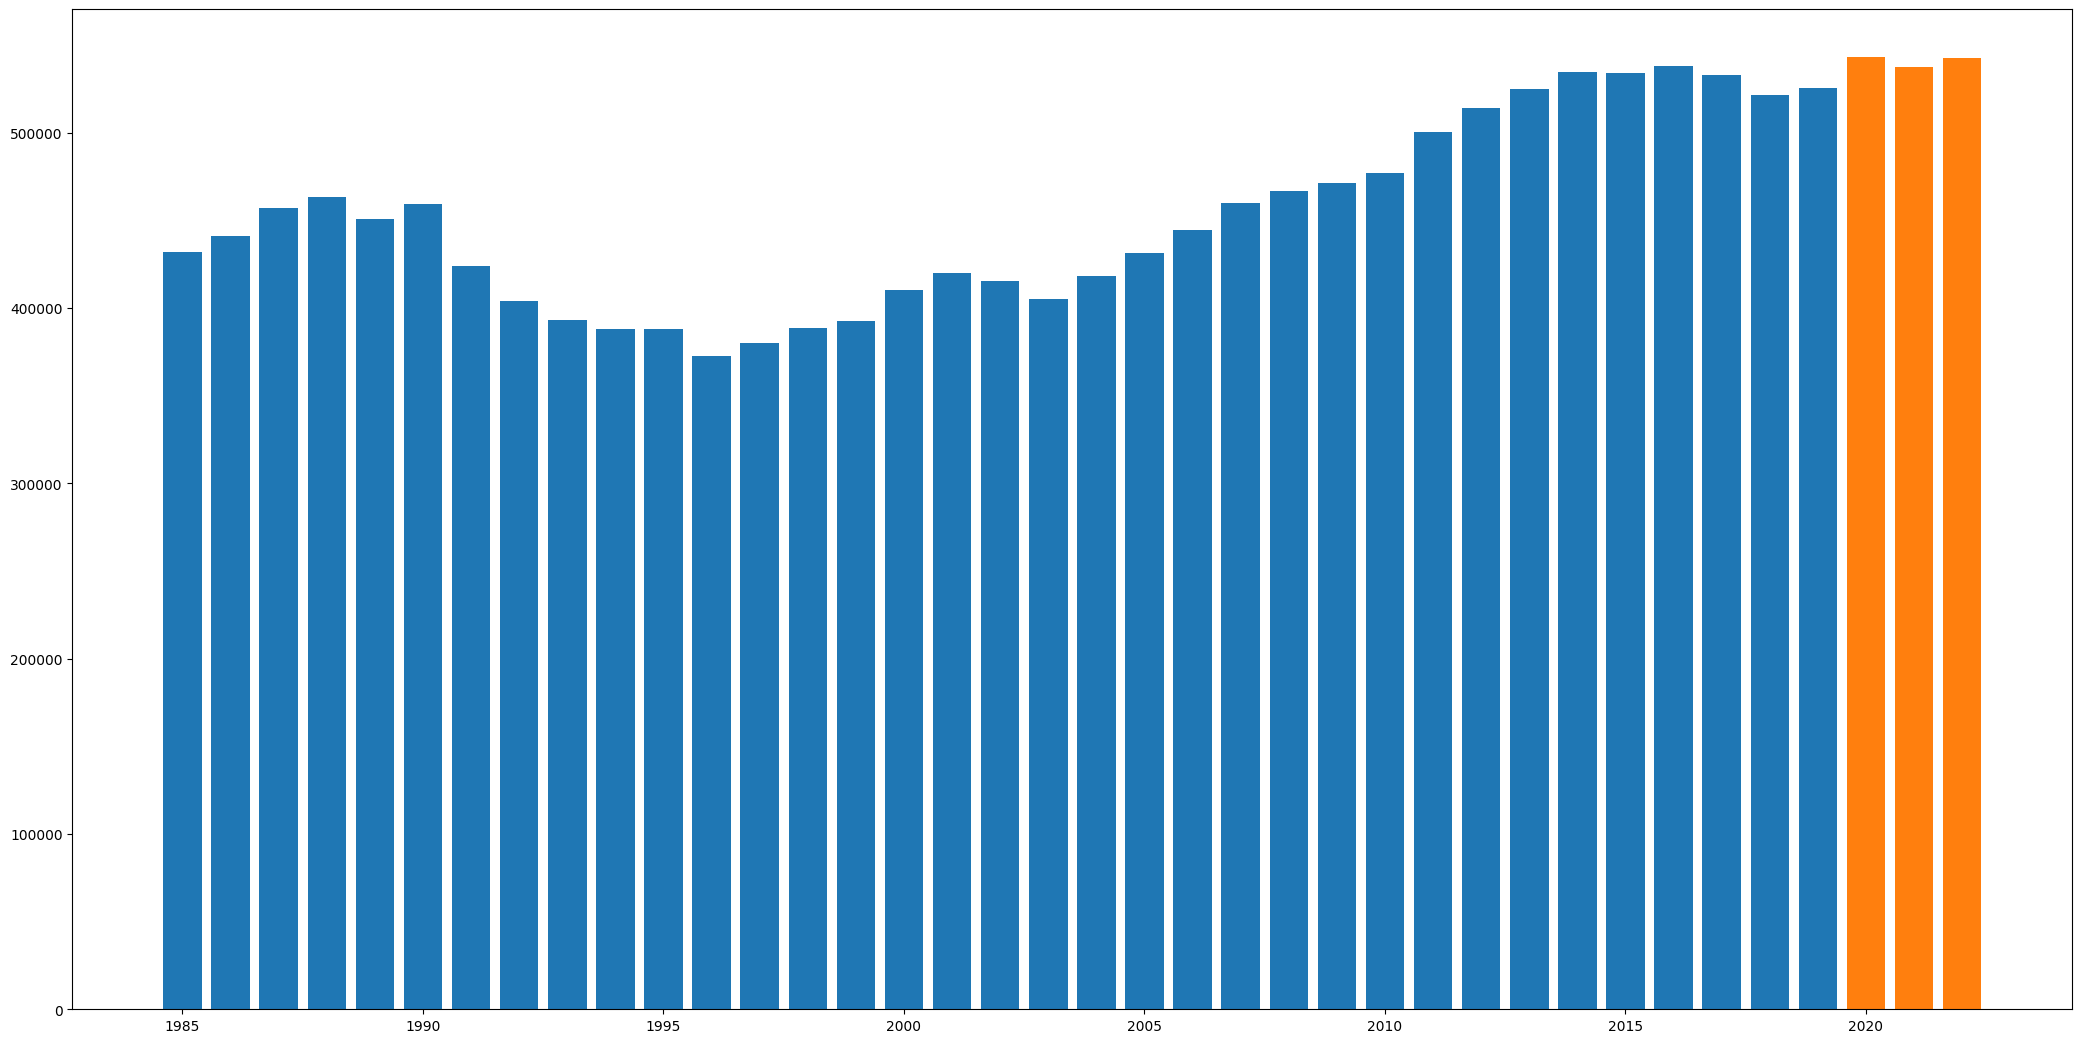

In [82]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = df['Year']
number_of_ppl = df["N_PPL"]
ax.bar(langs,number_of_ppl)

pred_year = [2020,2021,2022]
pred_number_of_ppl = forecast_predicted
ax.bar(pred_year,pred_number_of_ppl)
plt.show()